In [28]:
from glob import glob

import flash
from flash.core.data.utils import download_data
from flash.image import ObjectDetectionData, ObjectDetector
from flash.image.detection.output import FiftyOneDetectionLabelsOutput

from flash.core.integrations.fiftyone import visualize
from itertools import chain


In [29]:
model = ObjectDetector.load_from_checkpoint("monkeydetection_faster_rcnn_resnet50_fpn_30epochs.pt")

Using 'efficientdet' provided by airctic/IceVision (https://github.com/airctic/icevision) and rwightman/efficientdet-pytorch (https://github.com/rwightman/efficientdet-pytorch).


In [31]:
predict_files = glob("video3/video3-opencv/*.jpg")

len(predict_files)

2972

In [32]:

trainer = flash.Trainer()
predict_dataset = ObjectDetectionData.from_files(
    predict_files=predict_files,
    batch_size=1, 
    transform_kwargs={"image_size": 256},
)
predictions = trainer.predict(
    model,
    datamodule=predict_dataset,
    output="fiftyone"
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
Using 'fiftyone' provided by voxel51/fiftyone (https://github.com/voxel51/fiftyone).
C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\pytorch_lightning\trainer\data_loading.py:132: UserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting:   0%|          | 1/2972 [00:00<05:38,  8.77it/s]

C:\Users\USER\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\effdet\bench.py:45: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  indices_all = cls_topk_indices_all // num_classes


Predicting: 100%|██████████| 2972/2972 [05:30<00:00,  8.99it/s]


In [33]:
predictions = list(chain.from_iterable(predictions))

In [34]:
session = visualize(predictions, wait=True)

 100% |███████████████| 2972/2972 [1.7s elapsed, 0s remaining, 1.7K samples/s]         


Notebook sessions cannot wait


In [35]:
import fiftyone as fo
import json
import pandas as pd

In [ ]:
# coco_dict = json.load(open("coco_monkey_annotation.json", "r"))
# ground_truth = pd.DataFrame(coco_dict["images"]).merge(pd.DataFrame(coco_dict["annotations"])).to_dict("records")

In [36]:
predictions[0]

{'filepath': 'video3/video3-opencv\\frame0-00-01.00.jpg',
 'predictions': <Detections: {
     'detections': BaseList([
         <Detection: {
 
             'id': '623b3f4551a7af69a3029e67',
 
             'attributes': BaseDict({}),
 
             'tags': BaseList([]),
 
             'label': '1',
 
             'bounding_box': BaseList([
 
                 0.5546557903289795,
 
                 0.5231500864028931,
 
                 0.19810724258422852,
 
                 0.1846252679824829,
 
             ]),
 
             'mask': None,
 
             'confidence': 0.8627294898033142,
 
             'index': None,
 
         }>,
         <Detection: {
 
             'id': '623b3f4551a7af69a3029e68',
 
             'attributes': BaseDict({}),
 
             'tags': BaseList([]),
 
             'label': '1',
 
             'bounding_box': BaseList([
 
                 0.3595784306526184,
 
                 0.4065641462802887,
 
                 0.11141222715377808,
 
                

In [ ]:
for i in range(len(predictions)):
    if len(predictions[i]["predictions"]["detections"]) == 0 :
        print ("name", i+1)
    print (len(predictions[i]["predictions"]["detections"]))
    

In [37]:
def find_center_bbox(detection, file_path) :

    x, y, w, h = detection["bounding_box"]
    im = Image.open(file_path)
    w_im, h_im = im.size
    x, y, w, h = (int(x * w_im), int(y * h_im), int(w * w_im), int(h * h_im))
    x_center, y_center = ((x + x + w) / 2, (y + y+ h) / 2)

    return  (x_center, y_center)

In [ ]:
# import pandas as pd
# df = pd.DataFrame([{"a": 1, "b": 3}, {"a": 2, "b": 5}])
# df.to_csv("example.csv", index=False)

In [38]:
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

positions = []
k = 60
for i, prediction in tqdm(enumerate(predictions)) :

    print("time : ", k , "sec")
    detections = prediction["predictions"]["detections"]
    n_detection = len(detections)
    file_path = prediction['filepath']

    if n_detection == 2 :
        x_center_1, y_center_1 = find_center_bbox(detections[0], file_path)
        x_center_2, y_center_2 = find_center_bbox(detections[1], file_path)

        if x_center_1 < x_center_2:
            positions.append({"monkey_id": 1, "x": x_center_1, "y": y_center_1})
            positions.append({"monkey_id": 2, "x": x_center_2, "y": y_center_2})
        else:
            positions.append({"monkey_id": 1, "x": x_center_2, "y": y_center_2})
            positions.append({"monkey_id": 2, "x": x_center_1, "y": y_center_1})

    elif n_detection == 1:
        x_center, y_center = find_center_bbox(detections[0], file_path)

        if x_center < 1000:
            positions.append({"monkey_id": 1, "x": x_center, "y": y_center})
            positions.append({"monkey_id": 2, "x": np.nan , "y": np.nan})
        else:
            positions.append({"monkey_id": 1, "x": np.nan, "y": np.nan})
            positions.append({"monkey_id": 2, "x": x_center , "y": y_center})

    else :
        positions.append({"monkey_id": 1, "x": np.nan, "y": np.nan})
        positions.append({"monkey_id": 2, "x": np.nan, "y": np.nan})
    
    

138it [00:00, 1379.67it/s]

time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60

426it [00:00, 1426.25it/s]

time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60

749it [00:00, 1464.95it/s]

time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60

1048it [00:00, 1470.34it/s]


time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  6

1363it [00:00, 1529.17it/s]

time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60

1517it [00:01, 1491.33it/s]

time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60

1828it [00:01, 1524.46it/s]

time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60

2133it [00:01, 1479.39it/s]

time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60

2428it [00:01, 1430.92it/s]

time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60

2716it [00:01, 1422.24it/s]

sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :

2972it [00:02, 1450.77it/s]

time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60 sec
time :  60

In [40]:
import pandas as pd

positions_df = pd.DataFrame(positions) 
monkey_df = positions_df.query("monkey_id == 1")
monkey_df["t"] =  [i for i in range(1, len(monkey_df) + 1)]
monkey_df.to_csv("monkey_right.csv",index=False)

<ipython-input-40-8886f21fd3c7>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monkey_df["t"] =  [i for i in range(1, len(monkey_df) + 1)]


In [ ]:
monkey_df

In [ ]:
positions_df.query("monkey_id == 1").to_csv("monkey_left.csv",index=False)

In [ ]:
positions_df.query("monkey_id == 2").to_csv("monkey_right.csv",index=False)

<ipython-input-45-fd7f72410553>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monkey_df["frames"] = np.arange(len(monkey_df))
<ipython-input-45-fd7f72410553>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monkey_df["x_median"] = monkey_df["x"].rolling(5).median()
<ipython-input-45-fd7f72410553>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

<AxesSubplot:xlabel='frames'>

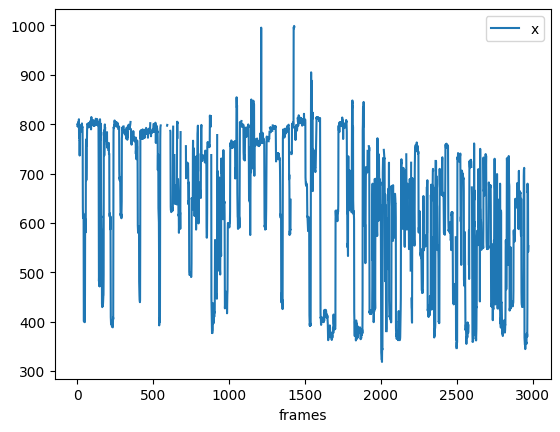

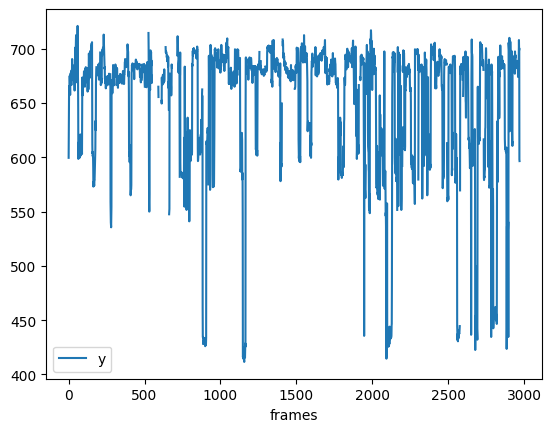

In [45]:
monkey_df = positions_df.query("monkey_id == 1")

monkey_df["frames"] = np.arange(len(monkey_df))
monkey_df["x_median"] = monkey_df["x"].rolling(5).median()
monkey_df["y_median"] = monkey_df["y"].rolling(5).median()

monkey_df.plot(x="frames", y="x", kind="line")
monkey_df.plot(x="frames", y="y", kind="line")

In [ ]:
# ''' monkey1, monkey2 = [], [] '''

# if len(bounding_boxes) == 1: ...
# elif len(bounding_boxes) == 2: ...
# else: monkey1.append({time: ..., x: np.nan, y: np.nan})
# monkey2.append({time: ..., x: np.nan, y: np.nan})

# monkey1.append({time: ..., x: x + w/2, y: y + h/2})
# monkey2.append({time: ..., x: np.nan, y: np.nan})

# monkey1_df = pd.DataFrame(monkey1)
# monkey2_df = pd.DataFrame(monkey2)

# monkey1_df[["x", "y"]].rolling(3).median() --> NaN